In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf

tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
train_df = pd.read_csv("../input/Kannada-MNIST/train.csv")
test_df = pd.read_csv("../input/Kannada-MNIST/test.csv")


features = train_df.iloc[:,1:].values
targets = train_df.iloc[:,0].values
validation = test_df.iloc[:,1:].values

print("training images shape {}".format(features.shape))
print("training labels shape {}".format(targets.shape))
print("validation images shape {}".format(validation.shape))

training images shape (60000, 784)
training labels shape (60000,)
validation images shape (5000, 784)


In [3]:
# reshape images

flattened_features = features.reshape(features.shape[0], 28, 28, 1)
flattened_validation = validation.reshape(validation.shape[0], 28, 28, 1)

print("x_flattened size {}".format(flattened_features.shape))
print("val_flattened size {}".format(flattened_validation.shape))

x_flattened size (60000, 28, 28, 1)
val_flattened size (5000, 28, 28, 1)


In [4]:
def normalize_data(df):
  df = df / 255.
  return df

normalized_features = normalize_data(flattened_features)
normalized_validation = normalize_data(flattened_validation)

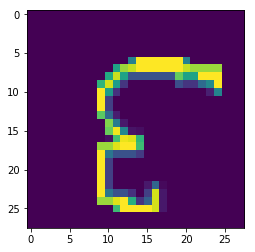

In [5]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# test train split

X_train, X_test, y_train, y_test = train_test_split(normalized_features, targets, test_size=0.2, random_state=7)

# viz
plt.imshow(X_train[0][:,:,0])

In [6]:
# Build CNN with Keras
# standard, with the addition of swish!

# Config
EPOCHS = 250
BATCH_SIZE = 256
LEARNING_RATE = 0.001 # 0.002

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import backend as k

# add custom swish activation function
from tensorflow.keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

from tensorflow.keras.layers import Activation
tf.keras.utils.get_custom_objects().update({'swish': Activation(swish)})

# Build model

model = Sequential()

# add layers
model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='Same', activation='swish', input_shape=(28, 28, 1)))
model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='Same', activation='swish', input_shape=(28, 28, 1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32, kernel_size=(2, 2), padding='Same', activation='swish'))
model.add(Conv2D(filters=32, kernel_size=(2, 2), padding='Same', activation='swish'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='swish'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

## optimizer
keras_optimizer = tf.keras.optimizers.Nadam(lr=LEARNING_RATE)

# Compile model
model.compile(optimizer=keras_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0

In [7]:
trained_model = model.fit(x=X_train, y=y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

Train on 48000 samples, validate on 12000 samples
Epoch 1/250
48000/48000 [==============================] - 11s 222us/sample - loss: 0.2495 - accuracy: 0.9240 - val_loss: 0.0501 - val_accuracy: 0.9848
Epoch 2/250
48000/48000 [==============================] - 4s 86us/sample - loss: 0.0516 - accuracy: 0.9846 - val_loss: 0.0321 - val_accuracy: 0.9908
Epoch 3/250
48000/48000 [==============================] - 4s 86us/sample - loss: 0.0349 - accuracy: 0.9891 - val_loss: 0.0244 - val_accuracy: 0.9927
Epoch 4/250
48000/48000 [==============================] - 4s 85us/sample - loss: 0.0265 - accuracy: 0.9914 - val_loss: 0.0275 - val_accuracy: 0.9924
Epoch 5/250
48000/48000 [==============================] - 4s 85us/sample - loss: 0.0219 - accuracy: 0.9933 - val_loss: 0.0188 - val_accuracy: 0.9941
Epoch 6/250
48000/48000 [==============================] - 4s 86us/sample - loss: 0.0186 - accuracy: 0.9939 - val_loss: 0.0173 - val_accuracy: 0.9948
Epoch 7/250
48000/48000 [=======================

In [8]:
sample_submission = pd.read_csv("../input/Kannada-MNIST/sample_submission.csv")

class_predictions = model.predict_classes(normalized_validation)

sample_submission['label'] = pd.Series(class_predictions)

sample_submission.to_csv("submission.csv",index=False)